<img width="150" alt="Logo_ER10" src="https://user-images.githubusercontent.com/3244249/151994514-b584b984-a148-4ade-80ee-0f88b0aefa45.png">

### Model Interpretation using LIME for penguin dataset classifier
This notebook demonstrates the use of DIANNA with the LIME tabular method on the penguins dataset.

LIME (Local Interpretable Model-agnostic Explanations) is an explainable-AI method that aims to create an interpretable model that locally represents the classifier. For more details see the [LIME paper](https://arxiv.org/abs/1602.04938).

Colab setup

In [1]:
running_in_colab = 'google.colab' in str(get_ipython())
if running_in_colab:
  # install dianna
  !python3 -m pip install dianna[notebooks]
  
  # download data used in this demo
  import os 
  base_url = 'https://raw.githubusercontent.com/dianna-ai/dianna/main/tutorials/'
  paths_to_download = ['models/penguin_model.onnx']
  for path in paths_to_download:
      !wget {base_url + path} -P {os.path.dirname(path)}

### Import libraries

In [2]:
import dianna
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from dianna.utils.onnx_runner import SimpleModelRunner

#### 1 - Loading the data
Load penguins dataset.

In [3]:
penguins = sns.load_dataset('penguins')

Prepare the data

In [4]:
# Remove categorial columns and NaN values
penguins_filtered = penguins.drop(columns=['island', 'sex']).dropna()

# Get the species
species = penguins['species'].unique()

# Extract inputs and target
input_features = penguins_filtered.drop(columns=['species'])
target = pd.get_dummies(penguins_filtered['species'])

# Let's explore the features of the dataset
input_features

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,39.1,18.7,181.0,3750.0
1,39.5,17.4,186.0,3800.0
2,40.3,18.0,195.0,3250.0
4,36.7,19.3,193.0,3450.0
5,39.3,20.6,190.0,3650.0
...,...,...,...,...
338,47.2,13.7,214.0,4925.0
340,46.8,14.3,215.0,4850.0
341,50.4,15.7,222.0,5750.0
342,45.2,14.8,212.0,5200.0


The data-set currently has four features that were used to train the model: bill length, bill depth, flipper length, and body mass. These features were used to classify the different species.

Training, validation, and test data split.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(input_features, target, test_size=0.2,
                                                    random_state=0, shuffle=True, stratify=target)

Get an instance to explain.

In [ ]:
# get an instance from test data
data_instance = X_test.iloc[10].to_numpy()

#### 2. Loading ONNX model
DIANNA supports ONNX models. Here we demonstrate the use of LIME explainer for tabular data with a pre-trained ONNX model, which is a MLP classifier for the penguins dataset. <br>

The model is trained following this notebook: <br>
https://github.com/dianna-ai/dianna-exploration/blob/main/example_data/model_generation/penguin_species/generate_model.ipynb

In [7]:
# load onnx model and check the prediction with it
model_path = './models/penguin_model.onnx'
loaded_model = SimpleModelRunner(model_path)
predictions = loaded_model(data_instance.reshape(1,-1).astype(np.float32))
species[np.argmax(predictions)]

'Gentoo'

A runner function is created to prepare data for the ONNX inference session.

In [8]:
import onnxruntime as ort

def run_model(data):
    # get ONNX predictions
    sess = ort.InferenceSession(model_path)
    input_name = sess.get_inputs()[0].name
    output_name = sess.get_outputs()[0].name

    onnx_input = {input_name: data.astype(np.float32)}
    pred_onnx = sess.run([output_name], onnx_input)[0]
    pred_onnx
    
    return pred_onnx

#### 3. Applying LIME with DIANNA
The simplest way to run DIANNA on image data is with `dianna.explain_tabular`.

DIANNA requires input in numpy format, so the input data is converted into a numpy array.

In [9]:
explanation = dianna.explain_tabular(run_model, input_tabular=data_instance, method='lime',
                                     mode ='classification', training_data = X_train.to_numpy(),
                                     feature_names=input_features.columns, class_names=species,
                                     discretize_continuous=True)

#### 4. Visualization
(TODO:) The output can be visualized with the DIANNA built-in visualization function. It shows the importance of each feature contributing to the prediction.

The prediction is "Gentoo", so let's visualize the feature importance scores for "Gentoo".

It can be noticed that the body mass feature has the biggest weight in the prediction.

In [10]:
# get the scores for the target class
explanation = explanation[np.argmax(predictions)]

# rank the results based on the absolute values
# and pick up the top 10 of them
num_features = 10
abs_values = [abs(i) for i in explanation]
top_values = [x for _, x in sorted(zip(abs_values, explanation), reverse=True)][:num_features]
top_features = [x for _, x in sorted(zip(abs_values, X_test.columns), reverse=True)][:num_features]

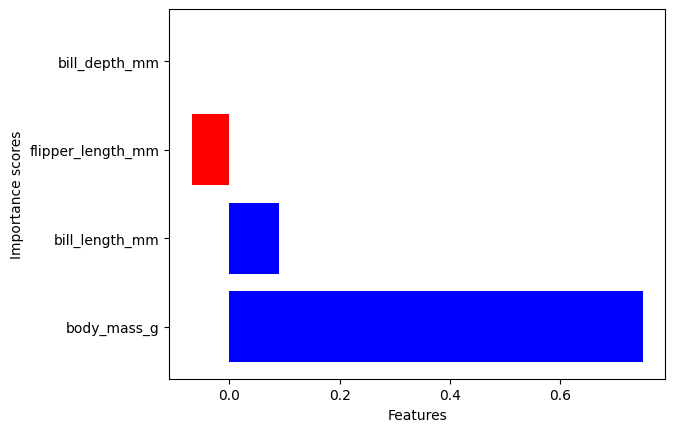

In [11]:
from matplotlib import pyplot as plt

colors = ['b' if x >= 0 else 'r' for x in top_values]

plt.barh(top_features, top_values, color=colors)
plt.xlabel("Features")
plt.ylabel("Importance scores")
plt.show()